# Learning To Rank

In [1]:
import pandas as pd
import numpy as np

from sklearn import model_selection
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers



import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tfr

from tensorflow_ranking.python.keras import canned
from tensorflow_ranking.python.keras import estimator
from tensorflow_ranking.python.keras import feature
from tensorflow_ranking.python.keras import layers as layers_r
from tensorflow_ranking.python.keras import losses
from tensorflow_ranking.python.keras import metrics
from tensorflow_ranking.python.keras import model
from tensorflow_ranking.python.keras import network
from tensorflow_ranking.python.keras import pipeline
from tensorflow_ranking.python.keras import saved_model
from tensorflow_ranking.python.keras import strategy_utils
from tensorflow_ranking.python.keras import utils


2022-06-17 18:48:32.819429: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-17 18:48:32.822143: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Importing Data

In [2]:
import pandas as pd

df = pd.read_csv('hotels5.csv')
df_cp = df.copy()
df_eval = df

df.head()

,Hotel,Star,Rating,Reviews,Harga,Places Nearby,Facil + Akomod
0,Hotel Indonesia Kempinski Jakarta,5.0,8.9,4363.0,2.480.500,Nearby Places\n\nJia Jia - Grand Indonesia (De...,Food and Drinks\nA la carte breakfast\nA la ca...
1,"The Langham, Jakarta",5.0,8.8,238.0,3.623.600,Nearby Places\n\nPig Me Up! - Ashta District 8...,Food and Drinks\nA la carte dinner\nA la carte...
2,Manhattan Hotel,5.0,8.5,8405.0,1.250.000,Nearby Places\n\nJia Jia - Grand Indonesia (De...,Hotel Services\nBellhop\nConcierge\nMoney chan...
3,Aloft South Jakarta,4.0,8.9,424.0,762.300,Nearby Places\n\nSouthside Rooftop Bar & Loung...,Public Facilities\nParking\nCoffee shop\nEleva...
4,"The Mayflower, Jakarta - Marriott Executive Ap...",5.0,9.0,393.0,1.756.254,Nearby Places\n\nSudirman Plaza\nBusiness\n2 m...,Food and Drinks\nA la carte breakfast\nA la ca...


# Preprocessing the Data

## Preprocessing facilities columns

In [3]:
facilities_columns = ['Food and Drinks','Hotel Services','In-room Facilities', 'Business Facilities', 'Nearby Facilities', 'Public Facilities', 'General', 'Things to Do', 'Accessibilty', 'Connectivity', 'Transportation', 'Kids and Pets', 'Sports and Recreations', 'Shuttle Service']

facilities_columns.reverse()

for index , row in df.iterrows():
    
    # split per fasil and akomod
    arr = row['Facil + Akomod'].splitlines() 
    #iterate over fasil and akomod

    i = 0
    count = 0

    for  item in reversed(arr):
      count += 1
      if item in facilities_columns:
        df.at[index,item ] = count
        count = 0
        i += 1
        
df = df.fillna(0)

## Preprocessing Places Nearby columns

In [4]:
for index , row in df.iterrows():
    
    # split per fasil and akomod
    arr = row['Places Nearby'].splitlines() 
    
    #iterate over fasil and akomod

    i = 0
    count = 0
    
    for ind, item in enumerate(arr):
        itemsplits = item.split()
        for x in itemsplits:
            if x.isdigit():
                if itemsplits[1] == "km":
                    meters = itemsplits[0] * 1000
                else:
                    meters = itemsplits[0]
                    
                if meters.isdigit():
                    df.at[index,arr[ind-1]] = meters
                    #print(meters)
                    
df = df.fillna(15000)

In [5]:
df.Harga = df['Harga'].str.replace('.','', regex = True).str.replace(',','.', regex = True).astype(float).astype(int)

In [6]:
df

,Hotel,Star,Rating,Reviews,Harga,Places Nearby,Facil + Akomod,Shuttle Service,Sports and Recreations,Kids and Pets,...,Fine Dining,Sport,Quick Bites,Education,Street Food,Activity & Games,Cafe,Entertainment,Food Court,Sight & Landmark
0,Hotel Indonesia Kempinski Jakarta,5.0,8.9,4363.0,2480500,Nearby Places\n\nJia Jia - Grand Indonesia (De...,Food and Drinks\nA la carte breakfast\nA la ca...,2.0,3.0,4.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000
1,"The Langham, Jakarta",5.0,8.8,238.0,3623600,Nearby Places\n\nPig Me Up! - Ashta District 8...,Food and Drinks\nA la carte dinner\nA la carte...,0.0,2.0,3.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000
2,Manhattan Hotel,5.0,8.5,8405.0,1250000,Nearby Places\n\nJia Jia - Grand Indonesia (De...,Hotel Services\nBellhop\nConcierge\nMoney chan...,2.0,3.0,3.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000
3,Aloft South Jakarta,4.0,8.9,424.0,762300,Nearby Places\n\nSouthside Rooftop Bar & Loung...,Public Facilities\nParking\nCoffee shop\nEleva...,0.0,2.0,0.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000
4,"The Mayflower, Jakarta - Marriott Executive Ap...",5.0,9.0,393.0,1756254,Nearby Places\n\nSudirman Plaza\nBusiness\n2 m...,Food and Drinks\nA la carte breakfast\nA la ca...,2.0,3.0,7.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,POP! Hotel Airport Jakarta,2.0,7.9,11026.0,385200,Nearby Places\n\nsTREATs Restaurant - Ibis Sty...,Hotel Services\nBellhop\n24-hour security\nLug...,2.0,0.0,0.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000
85,Sheraton Grand Jakarta Gandaria City Hotel,5.0,8.9,1511.0,2420000,Nearby Places\n\nAnigre at Sheraton Gandaria\n...,Food and Drinks\nA la carte breakfast\nA la ca...,2.0,0.0,0.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000
86,Horison Suites & Residences Rasuna Jakarta,4.0,7.8,517.0,688000,Nearby Places\n\nMeZZa Restaurant at Aston Ras...,General\nAC\nBallroom\nBanquet\nFamily room\nN...,0.0,0.0,0.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000
87,grandkemang Hotel,4.0,8.4,2717.0,431250,Nearby Places\n\nSparca Lounge at grandkemang ...,Food and Drinks\nA la carte dinner\nA la carte...,2.0,3.0,0.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000


In [7]:
c = df.select_dtypes(object).columns
df[c] = df[c].apply(pd.to_numeric,errors='coerce')

In [8]:
df.columns

Index(['Hotel', 'Star', 'Rating', 'Reviews', 'Harga', 'Places Nearby',
       'Facil + Akomod', 'Shuttle Service', 'Sports and Recreations',
       'Kids and Pets', 'Transportation', 'Connectivity', 'Accessibilty',
       'Things to Do', 'General', 'Public Facilities', 'Nearby Facilities',
       'Business Facilities', 'In-room Facilities', 'Hotel Services',
       'Food and Drinks', 'Fast Food', 'Shop & Gifts', 'Business',
       'Transportation Hub', 'Casual Dining', 'Nightlife', 'Park & Zoo',
       'Public Service', 'Arts & Sciences', 'Fine Dining', 'Sport',
       'Quick Bites', 'Education', 'Street Food', 'Activity & Games', 'Cafe',
       'Entertainment', 'Food Court', 'Sight & Landmark'],
      dtype='object')

## Make score columns (Higher hotel get higher score)

In [9]:
a = []

for x in range(90,1,-1):
    a.append(x)
    
print(a)

df['Score'] = a
df

[90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2]


,Hotel,Star,Rating,Reviews,Harga,Places Nearby,Facil + Akomod,Shuttle Service,Sports and Recreations,Kids and Pets,...,Sport,Quick Bites,Education,Street Food,Activity & Games,Cafe,Entertainment,Food Court,Sight & Landmark,Score
0,NaN,5.0,8.9,4363.0,2480500,NaN,NaN,2.0,3.0,4.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,90
1,NaN,5.0,8.8,238.0,3623600,NaN,NaN,0.0,2.0,3.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,89
2,NaN,5.0,8.5,8405.0,1250000,NaN,NaN,2.0,3.0,3.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,88
3,NaN,4.0,8.9,424.0,762300,NaN,NaN,0.0,2.0,0.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,87
4,NaN,5.0,9.0,393.0,1756254,NaN,NaN,2.0,3.0,7.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,NaN,2.0,7.9,11026.0,385200,NaN,NaN,2.0,0.0,0.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,6
85,NaN,5.0,8.9,1511.0,2420000,NaN,NaN,2.0,0.0,0.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,5
86,NaN,4.0,7.8,517.0,688000,NaN,NaN,0.0,0.0,0.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,4
87,NaN,4.0,8.4,2717.0,431250,NaN,NaN,2.0,3.0,0.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,3


In [10]:
df.sort_values(['Harga'])

,Hotel,Star,Rating,Reviews,Harga,Places Nearby,Facil + Akomod,Shuttle Service,Sports and Recreations,Kids and Pets,...,Sport,Quick Bites,Education,Street Food,Activity & Games,Cafe,Entertainment,Food Court,Sight & Landmark,Score
81,NaN,3.0,8.0,12732.0,382400,NaN,NaN,0.0,0.0,0.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,9
84,NaN,2.0,7.9,11026.0,385200,NaN,NaN,2.0,0.0,0.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,6
87,NaN,4.0,8.4,2717.0,431250,NaN,NaN,2.0,3.0,0.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,3
58,NaN,4.0,8.6,3747.0,432000,NaN,NaN,10.0,4.0,3.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,32
88,NaN,2.0,8.3,8445.0,446400,NaN,NaN,2.0,0.0,0.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,NaN,5.0,8.6,2126.0,4344540,NaN,NaN,3.0,2.0,0.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,83
76,NaN,5.0,9.0,1983.0,4501200,NaN,NaN,2.0,3.0,3.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,14
8,NaN,5.0,8.9,365.0,5504291,NaN,NaN,4.0,0.0,2.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,82
9,NaN,5.0,8.8,2860.0,5692687,NaN,NaN,2.0,10.0,4.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,81


# Understanding the Data (Data Visualization)

## Score and Star (x,y)

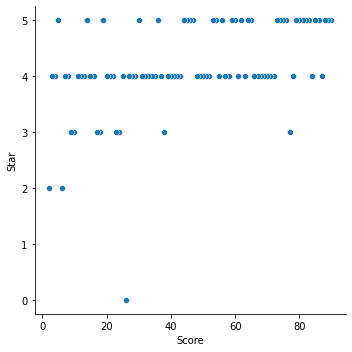

In [11]:
sns.relplot(x="Score", y="Star", data=df);

## Score and Reviews (x,y)

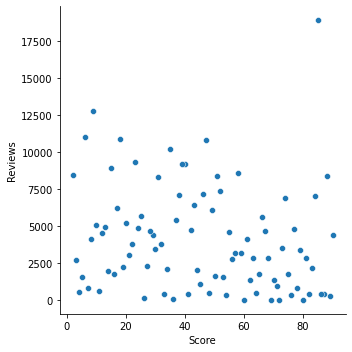

In [12]:
sns.relplot(x="Score", y="Reviews", data=df);

## Price and Score (x,y)

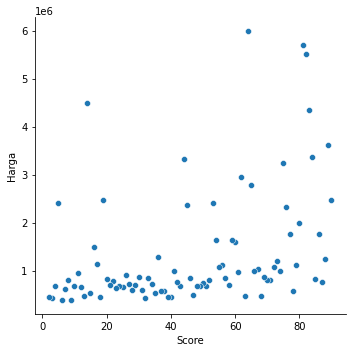

In [13]:
sns.relplot(x="Score", y="Harga", data=df);

## Score and Rating (x,y)

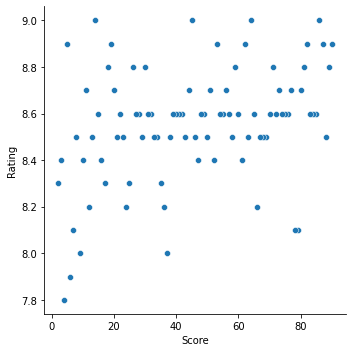

In [14]:
sns.relplot(x="Score", y="Rating", data=df);

## Reviewing Facilities Top Ranking Hotels

In [15]:
facilities = df[['Shuttle Service', 'Sports and Recreations',
       'Kids and Pets', 'Transportation', 'Connectivity', 'Accessibilty',
       'Things to Do', 'General', 'Public Facilities', 'Nearby Facilities',
       'Business Facilities', 'In-room Facilities', 'Hotel Services',
       'Food and Drinks'] ]
Places = df[['Fast Food', 'Shop & Gifts', 'Business',
       'Transportation Hub', 'Casual Dining', 'Nightlife', 'Park & Zoo',
       'Public Service', 'Arts & Sciences', 'Fine Dining', 'Sport',
       'Quick Bites', 'Education', 'Street Food', 'Activity & Games', 'Cafe',
       'Entertainment', 'Food Court', 'Sight & Landmark']]

<AxesSubplot:>

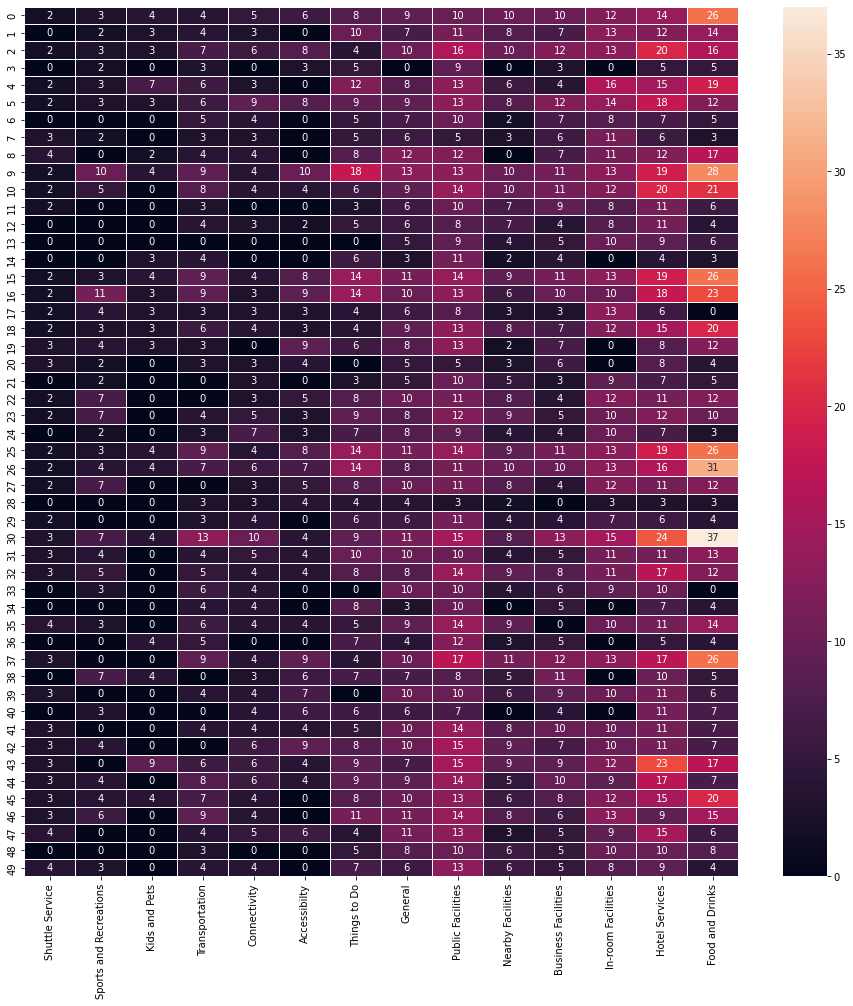

In [16]:
fig, ax = plt.subplots(figsize=(16,16))         # Sample figsize in inches
sns.heatmap(facilities.iloc[:50], annot=True, linewidths=.5, ax=ax)

<AxesSubplot:>

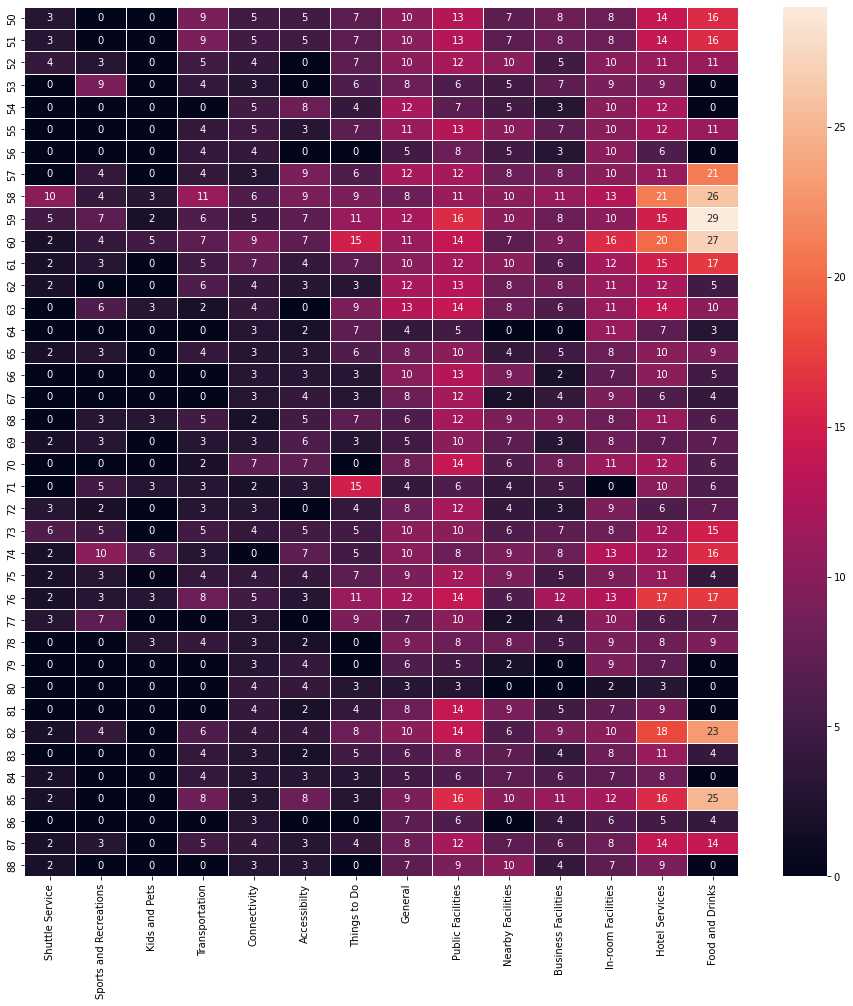

In [17]:
fig, ax = plt.subplots(figsize=(16,16))         # Sample figsize in inches
sns.heatmap(facilities.iloc[50:], annot=True, linewidths=.5, ax=ax)

<AxesSubplot:>

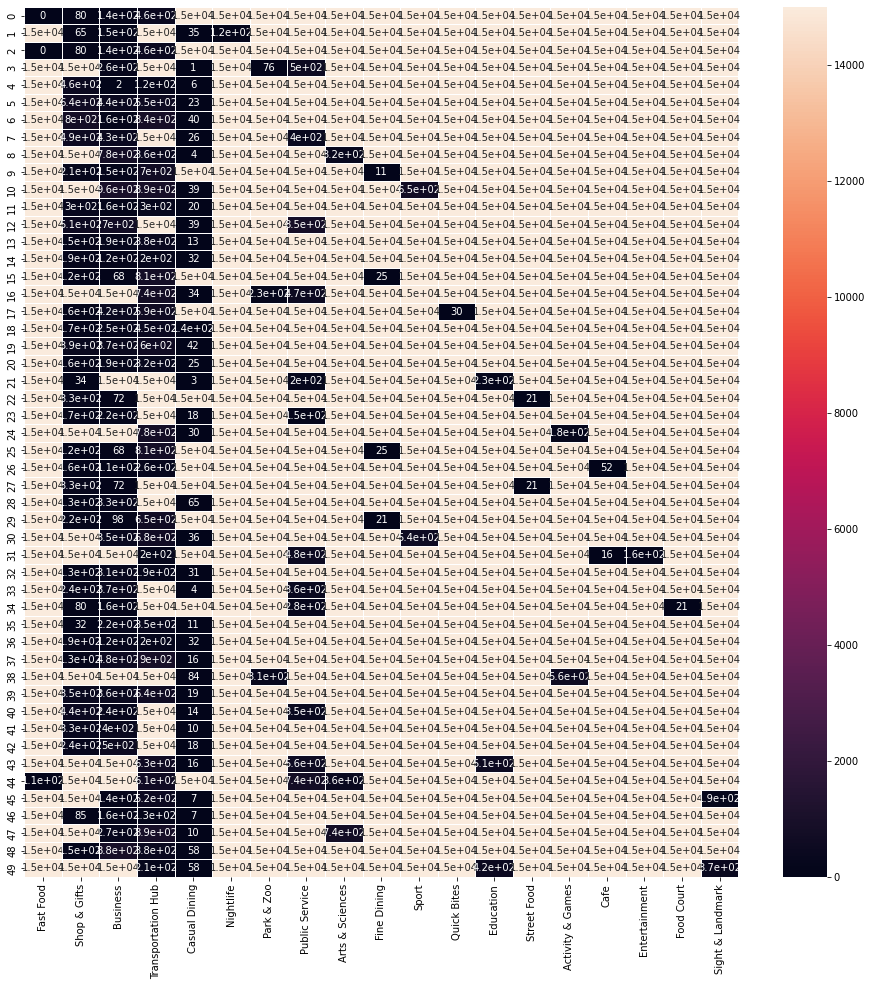

In [18]:
fig, ax = plt.subplots(figsize=(16,16))         # Sample figsize in inches
sns.heatmap(Places.iloc[:50], annot=True, linewidths=.5, ax=ax)

<AxesSubplot:>

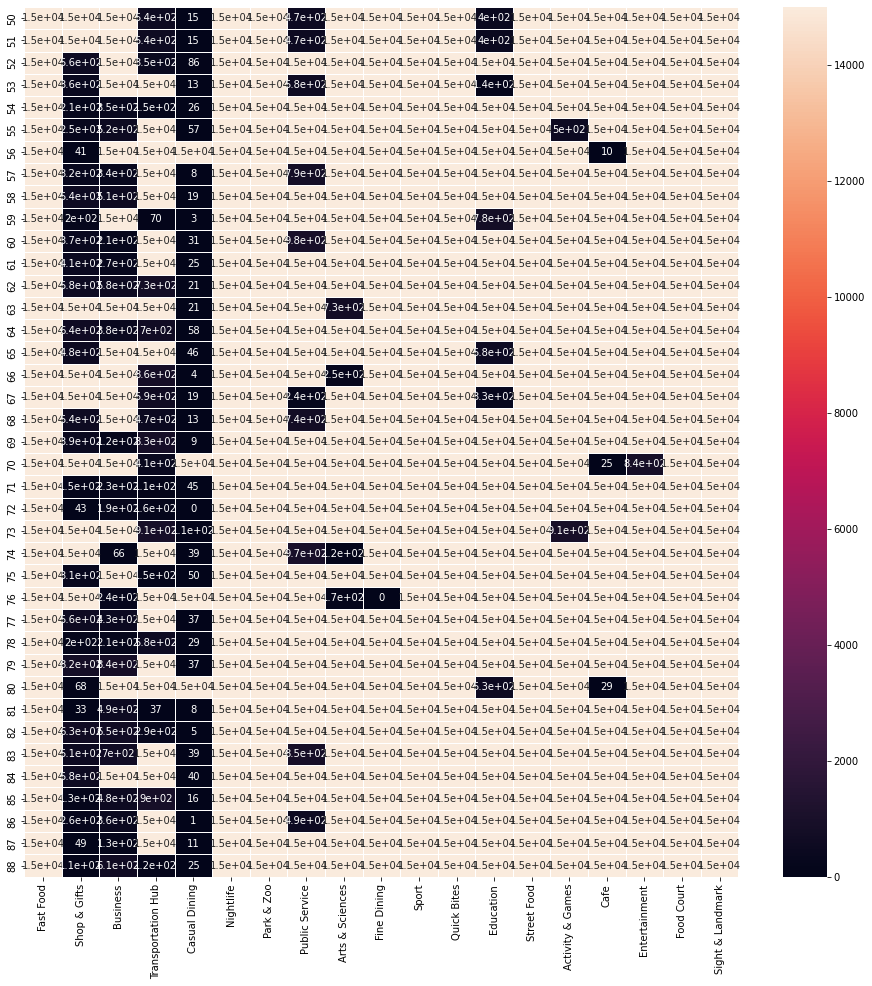

In [19]:
fig, ax = plt.subplots(figsize=(16,16))         # Sample figsize in inches
sns.heatmap(Places.iloc[50:], annot=True, linewidths=.5, ax=ax)

# Building Tensorflow Regression Pipeline

## Prepare the input (Normalizers)

In [20]:
train_features = df.drop(['Hotel','Score','Places Nearby','Facil + Akomod','Fast Food', 'Shop & Gifts', 'Business',
       'Transportation Hub', 'Casual Dining', 'Nightlife', 'Park & Zoo',
       'Public Service', 'Arts & Sciences', 'Fine Dining', 'Sport',
       'Quick Bites', 'Education', 'Street Food', 'Activity & Games', 'Cafe',
       'Entertainment', 'Food Court', 'Sight & Landmark'], axis = 1)

train_features

,Star,Rating,Reviews,Harga,Shuttle Service,Sports and Recreations,Kids and Pets,Transportation,Connectivity,Accessibilty,Things to Do,General,Public Facilities,Nearby Facilities,Business Facilities,In-room Facilities,Hotel Services,Food and Drinks
0,5.0,8.9,4363.0,2480500,2.0,3.0,4.0,4.0,5.0,6.0,8.0,9.0,10.0,10.0,10.0,12.0,14.0,26.0
1,5.0,8.8,238.0,3623600,0.0,2.0,3.0,4.0,3.0,0.0,10.0,7.0,11.0,8.0,7.0,13.0,12.0,14.0
2,5.0,8.5,8405.0,1250000,2.0,3.0,3.0,7.0,6.0,8.0,4.0,10.0,16.0,10.0,12.0,13.0,20.0,16.0
3,4.0,8.9,424.0,762300,0.0,2.0,0.0,3.0,0.0,3.0,5.0,0.0,9.0,0.0,3.0,0.0,5.0,5.0
4,5.0,9.0,393.0,1756254,2.0,3.0,7.0,6.0,3.0,0.0,12.0,8.0,13.0,6.0,4.0,16.0,15.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2.0,7.9,11026.0,385200,2.0,0.0,0.0,4.0,3.0,3.0,3.0,5.0,6.0,7.0,6.0,7.0,8.0,0.0
85,5.0,8.9,1511.0,2420000,2.0,0.0,0.0,8.0,3.0,8.0,3.0,9.0,16.0,10.0,11.0,12.0,16.0,25.0
86,4.0,7.8,517.0,688000,0.0,0.0,0.0,0.0,3.0,0.0,0.0,7.0,6.0,0.0,4.0,6.0,5.0,4.0
87,4.0,8.4,2717.0,431250,2.0,3.0,0.0,5.0,4.0,3.0,4.0,8.0,12.0,7.0,6.0,8.0,14.0,14.0


In [21]:
train_labels = df['Score']
train_labels

0     90
1     89
2     88
3     87
4     86
      ..
84     6
85     5
86     4
87     3
88     2
Name: Score, Length: 89, dtype: int64

# Normalizer for input

In [22]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

2022-06-17 18:48:49.396796: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-17 18:48:49.396848: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-17 18:48:49.396880: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gusanwa): /proc/driver/nvidia/version does not exist
2022-06-17 18:48:49.397246: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[[4.1685390e+00 8.5550556e+00 4.0973481e+03 1.3512902e+06 1.7415731e+00
  2.6516852e+00 1.2247190e+00 4.2696629e+00 3.8089888e+00 3.7078652e+00
  6.3146067e+00 8.2022476e+00 1.1044945e+01 6.1685390e+00 6.4044943e+00
  9.1573038e+00 1.1617977e+01 1.0955056e+01]]


## Anti Overfitting Paramaters

In [23]:
regularizer = 0.000001
dropout = 0
schedul = -0.0001



lr = 0.001

## Building Deep Neural Networks Model

In [24]:
def small_model(norm):
  
    model = keras.Sequential([
      norm,
      layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(regularizer) ),
        layers.Dropout(dropout),
      layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
      layers.Dense(1)
      ])
    
    return model


def medium_model(norm):
  
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(regularizer) ),
      layers.Dropout(dropout),
      layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(regularizer) ),
      layers.Dropout(dropout),
      layers.Dense(1)
      ])
    
    return model


def large_model(norm):
  
    model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
      layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
      layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
      layers.Dense(1)
      ])
    
    return model

def scale_model(norm):
  
    model = keras.Sequential([
      norm,
      layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
      layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
      layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
         layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dropout(dropout),
      layers.Dense(1)
      ])
    
    return model

def scale_model2(norm):
    
    model = keras.Sequential([
    norm,
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
    layers.Dropout(dropout),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
    layers.Dropout(dropout),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
    layers.Dropout(dropout),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
    layers.Dropout(dropout),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
    layers.Dropout(dropout),
    layers.Dense(1)
    ])

    return model

## Schedulers and Optimizer

In [25]:
optimizer = tf.optimizers.Adam(learning_rate=lr)

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(schedul)

## Building the Pipeline

In [26]:
def DNN_Pipeline (model):
    
    model.compile(optimizer= optimizer, loss='mean_absolute_error')
    
    history = model.fit(
    train_features,
    train_labels,
    validation_split=0.8,
    callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler),
    verbose=0, epochs=300)
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.plot(history.history['loss'], label='loss')
    #lt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MAE]')
    plt.legend()
    plt.grid(True)
    print(hist.tail(10))
    
    return model

         loss   val_loss        lr  epoch
290  0.158033  34.479877  0.000972    290
291  0.458711  34.759926  0.000972    291
292  0.239459  34.826759  0.000972    292
293  0.253119  34.498909  0.000972    293
294  0.438284  34.640030  0.000972    294
295  0.263488  34.733627  0.000972    295
296  0.226083  34.677574  0.000972    296
297  0.167527  34.648743  0.000972    297
298  0.215452  34.656139  0.000972    298
299  0.112249  34.599575  0.000971    299


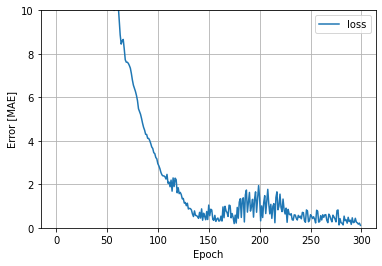

In [27]:
scale2 = DNN_Pipeline(scale_model2(normalizer))

         loss   val_loss        lr  epoch
290  0.787376  29.294298  0.000944    290
291  0.773936  29.359680  0.000944    291
292  0.720199  29.360268  0.000944    292
293  0.700798  29.311733  0.000944    293
294  0.725365  29.306580  0.000944    294
295  0.715819  29.338026  0.000944    295
296  0.659429  29.369219  0.000944    296
297  0.648012  29.364397  0.000944    297
298  0.656483  29.310560  0.000944    298
299  0.661061  29.314554  0.000944    299


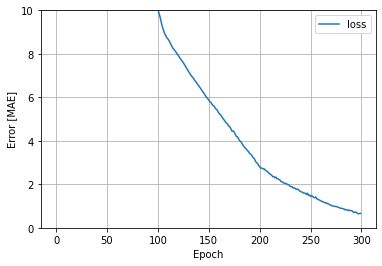

In [28]:
medium = DNN_Pipeline(medium_model(normalizer))

         loss   val_loss        lr  epoch
290  0.187943  31.921740  0.000917    290
291  0.200605  32.017647  0.000917    291
292  0.295208  31.697628  0.000917    292
293  0.488765  31.810930  0.000917    293
294  0.320447  32.150269  0.000917    294
295  0.626850  32.006290  0.000917    295
296  0.317105  31.602438  0.000917    296
297  0.828214  31.517435  0.000917    297
298  1.002477  31.820787  0.000917    298
299  0.415037  32.375656  0.000917    299


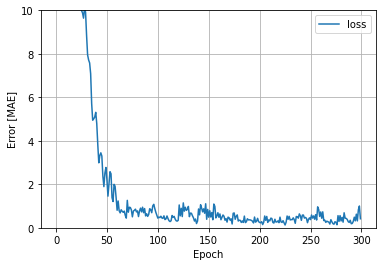

In [29]:
large = DNN_Pipeline(large_model(normalizer))

         loss   val_loss        lr  epoch
290  3.420402  31.593763  0.000891    290
291  1.591181  33.097271  0.000891    291
292  3.523116  32.404270  0.000891    292
293  2.039144  30.445339  0.000891    293
294  2.749980  30.271933  0.000891    294
295  3.386404  31.877892  0.000891    295
296  0.895124  33.565773  0.000891    296
297  3.267885  32.970463  0.000891    297
298  1.973682  30.535912  0.000891    298
299  3.294111  30.210978  0.000890    299


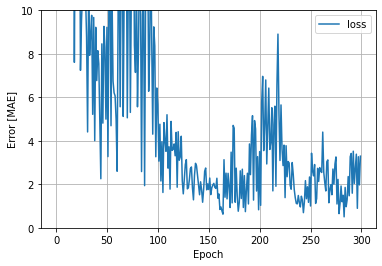

In [30]:
small = DNN_Pipeline(scale_model(normalizer))

In [31]:
df_ranking=df
df_ranking['Score'] = medium.predict(train_features)
df_ranking = df_ranking.sort_values(['Score'],ascending =False)
df_ranking

,Hotel,Star,Rating,Reviews,Harga,Places Nearby,Facil + Akomod,Shuttle Service,Sports and Recreations,Kids and Pets,...,Sport,Quick Bites,Education,Street Food,Activity & Games,Cafe,Entertainment,Food Court,Sight & Landmark,Score
30,NaN,5.0,8.6,7.007,1597200,NaN,NaN,3.0,7.0,4.0,...,545,15000,15000,15000,15000,15000,15000,15000,15000,121.941338
86,NaN,4.0,7.8,517.000,688000,NaN,NaN,0.0,0.0,0.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,106.194611
28,NaN,5.0,8.9,1361.000,2960301,NaN,NaN,0.0,0.0,0.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,103.044876
26,NaN,5.0,9.0,478.000,5995489,NaN,NaN,2.0,4.0,4.0,...,15000,15000,15000,15000,15000,52,15000,15000,15000,102.691803
80,NaN,3.0,8.4,5052.000,688710,NaN,NaN,0.0,0.0,0.0,...,15000,15000,526,15000,15000,29,15000,15000,15000,92.479897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,NaN,3.0,8.5,7110.000,570000,NaN,NaN,4.0,3.0,0.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,14.703479
35,NaN,4.0,8.6,4565.000,1077800,NaN,NaN,4.0,3.0,0.0,...,15000,15000,15000,15000,15000,15000,15000,15000,15000,13.162641
22,NaN,4.0,8.5,2860.000,476000,NaN,NaN,2.0,7.0,0.0,...,15000,15000,15000,21,15000,15000,15000,15000,15000,12.689483
27,NaN,4.0,8.5,2860.000,476000,NaN,NaN,2.0,7.0,0.0,...,15000,15000,15000,21,15000,15000,15000,15000,15000,12.689483


# Export the modelweight

In [32]:
medium.save_weights('./saved_model5/model_weight7.h5')

In [33]:
#df2 = pd.read_csv('https://storage.googleapis.com/data-hotel/list-hotel/Data%20API.csv')

# Count References scorer



# References limit = 5

In [34]:
def count_references_score(columns,df = df):
    
    places_columns = ['Fast Food', 'Shop & Gifts', 'Business',
       'Transportation Hub', 'Casual Dining', 'Nightlife', 'Park & Zoo',
       'Public Service', 'Arts & Sciences', 'Fine Dining', 'Sport',
       'Quick Bites', 'Education', 'Street Food', 'Activity & Games', 'Cafe',
       'Entertainment', 'Food Court', 'Sight & Landmark']
    
    columns_number = len(columns)
    
    c = 0
    score = []
    total_score = []
    
    for x in columns: 
        
        if x in places_columns:
            
            for j in df[x]:
                
                places_value = 1-(j/15000) 
                score.append(places_value)
                
            if c == 0:
                total_score = score
            else:
                total_score = np.add(score,total_score)
        
        else:
            max_count = df[x].max()
            
            for y in df[x]:
                score.append(y/max_count)

            if c == 0:
                total_score = score
            else:
                total_score = np.add(score,total_score)

        c =+1
        score = []
        
            
    return ((total_score/columns_number)*100  )

In [35]:
count_references_score(['Food and Drinks','Hotel Services','Fast Food'])

array([76.2012012 , 29.27927928, 75.52552553, 11.44894895, 37.95045045,
       35.81081081, 14.22672673, 11.03603604, 31.98198198, 51.61411411,
       46.6966967 , 20.68318318, 18.88138138, 17.90540541,  8.25825826,
       49.81231231, 45.72072072,  8.33333333, 38.85135135, 21.92192192,
       14.71471471, 14.22672673, 26.08858859, 25.67567568, 12.42492492,
       49.81231231, 50.15015015, 26.08858859,  6.86936937, 11.93693694,
       66.66666667, 26.98948949, 34.42192192, 13.88888889, 13.32582583,
       27.89039039, 10.54804805, 47.03453453, 18.39339339, 20.68318318,
       21.58408408, 21.58408408, 21.58408408, 47.25975976, 63.01297297,
       38.85135135, 26.01351351, 26.23873874, 21.0960961 , 16.1036036 ,
       33.85885886, 33.85885886, 25.18768769, 12.5       , 16.66666667,
       26.57657658,  8.33333333, 34.1966967 , 52.59009009, 46.95945946,
       52.1021021 , 36.14864865, 21.17117117, 28.45345345, 12.42492492,
       21.996997  , 18.39339339, 11.93693694, 20.68318318, 16.02

In [36]:
output = count_references_score(['Food and Drinks','Hotel Services','Fast Food']) + df_ranking.Score
output

30    198.142539
86    135.473890
28    178.570402
26    114.140752
80    130.430347
         ...    
52     25.814590
35     57.907385
22     23.237531
27     44.746540
73     22.718318
Name: Score, Length: 89, dtype: float64

In [37]:
df_output = pd.read_csv('https://storage.googleapis.com/data-hotel/list-hotel/dataset_output.csv')
df_output['Score'] = count_references_score(['Food and Drinks','Hotel Services','Fast Food','Business Facilities']) + df_ranking.Score
df_output = df_output.sort_values(['Score'], ascending = False)
df_output

,id,hotel,stars,rating,reviews,harga,places_nearby,facil_+_akomod,food_and_drinks_list,hotel_services_list,...,accessibilty_list,connectivity_list,transportation_list,kids_and_pets_list,sports_and_recreations_list,shuttle_service_list,description,imageUrl,kota,Score
30,30,The Sultan Hotel & Residence Jakarta,5.0,8.6,7.007,1.597.200,Nearby Places\nLagoon Cafe at The Sultan Hotel...,Facilities\nFood and Drinks\n\n A la carte ...,A la carte breakfast\n A la carte dinne...,Bellhop\n Welcoming drinks\n Concier...,...,Wheelchair accessible,INTERNATIONAL_CALL\n Internet point\n ...,Airport transfer\n Bicycle rental\n ...,CRIBS,Basketball\n Fitness center\n Outdoo...,Airport transfer (surcharge),This Hotel offers ultimate comfort and luxury....,https://imghtlak.mmtcdn.com/hotels/20070121051...,Jakarta,198.323008
28,28,InterContinental Hotels JAKARTA PONDOK INDAH,5.0,8.9,1361,2.960.301,Nearby Places\n\nOotoya - Pondok Indah Mall 2\...,Things to Do\nOutdoor pool\nFitness center\n\n...,Bar,Concierge,...,Accessibility equipment\nAccessible parking,WiFi (surcharge),Parking with surcharge,NaN,NaN,NaN,This Hotel offers ultimate comfort and luxury....,https://imghtlak.mmtcdn.com/hotels/20070121044...,Jakarta,182.765943
25,25,JW Marriott Hotel Jakarta,5.0,8.6,1755,2.785.783,Nearby Places\n\nPearl Chinese Restaurant at J...,Food and Drinks\nA la carte breakfast\nA la ca...,A la carte breakfast\nA la carte dinner\nA la ...,Bellhop\nWelcoming drinks\nConcierge\nMoney ch...,...,Accessibility equipment\nAccessible bathroom\n...,LAN Internet\nFree WiFi,Airport transfer\nArea shuttle\nLimo or town c...,Babysitting with surcharge\nHighchairs,Fitness center,Airport transfer (surcharge),This Hotel offers ultimate comfort and luxury....,https://imghtlak.mmtcdn.com/hotels/20070120130...,Jakarta,150.224655
43,43,Best Western Premier The Hive,5.0,8.4,"10,776",500,Nearby Places\nNebe Kitchen - The Hive \nCasua...,Hotel Services\n\n Bellhop\n Welcoming d...,Restaurant with AC\n Bar\n Breakfast...,Bellhop\n Welcoming drinks\n Concier...,...,Accessible bathroom,Internet point\n LAN Internet\n Free...,Car rental\n Secure parking\n Valet ...,Babysitting with surcharge\n Highchairs...,NaN,Airport transfer (surcharge),This Hotel offers ultimate comfort and luxury....,https://imghtlak.mmtcdn.com/hotels/20070125122...,Jakarta,148.856131
1,1,"The Langham, Jakarta",5.0,8.8,238,3.823.600,Nearby Places\n\nPig Me Up! - Ashta District 8...,Food and Drinks\nA la carte dinner\nA la carte...,A la carte dinner\nA la carte lunch\nBar\nBrea...,Bellhop\nConcierge\nDoorman\nFront desk\n24-ho...,...,NaN,Free WiFi,Secure parking\nValet parking,CRIBS,Fitness center,NaN,This Hotel offers ultimate comfort and luxury....,https://imghtlak.mmtcdn.com/hotels/20070110155...,Jakarta,145.086410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,52,Swiss-Belinn Simatupang Jakarta,3.0,8.5,"7,110",570,Nearby Places\nKarumba! Rooftop at Mercure Jak...,Public Facilities\n\n Parking\n Coffee/t...,A la carte dinner\n A la carte lunch\n ...,Bellhop\n 24-hour security\n Laundry...,...,NaN,LAN Internet,Airport transfer\n Car rental,NaN,Fitness center,Airport transfer (surcharge),This Hotel offers ultimate comfort and luxury....,https://imghtlak.mmtcdn.com/hotels/20070315061...,Jakarta,34.575274
22,22,Yuan Garden Pasar Baru,4.0,8.5,2860,476,Nearby Places\n\nKerak Telor Bang Doel\nStreet...,Food and Drinks\nA la carte dinner\nA la carte...,A la carte dinner\nA la carte lunch\nRestauran...,Bellhop\nConcierge\n24-hour Receptionist\n24-h...,...,Accessibility equipment\nAccessible bathroom\n...,Free WiFi,NaN,NaN,Aerobics\nFitness center\nFamily-friendly Faci...,Airport transfer (surcharge),This Hotel offers ultimate comfort and luxury....,https://imghtlak.mmtcdn.com/hotels/20070120121...,Jakarta,28.292826
73,73,Putri Duyung Ancol,3.0,8.3,6238,"1.144.000,00",Nearby Places\r\n\r\nThe Pier by Kalaha - Tama...,Food and Drinks\nA la carte breakfast\nA la ca...,A la carte br

In [38]:
import json

jsondata = {"key": ['Transportation', 'Connectivity', 'Shuttle Service']}
input_data = json.dumps(jsondata)
print(input_data)
Christell Project21.51
test = pd.read_json(json.dumps(data))
        test = test['interest']

SyntaxError: invalid syntax (497089348.py, line 6)